In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from functions import generate_data, rmse, hard_assign, mean_pred_error, est_log_evidence, chib_est_log_evidence
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

/home/troch/venvs/misc-python-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 2

### Question a)

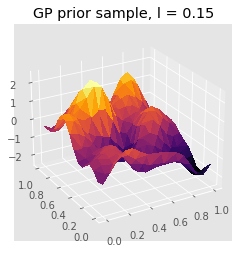

In [4]:
l = 0.15
D = 16
x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
N = D**2

plot_3D(u, x, y, title=f'GP prior sample, l = {l}')                            

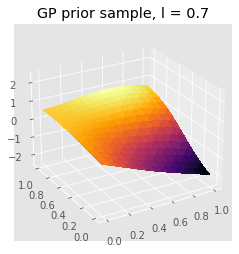

In [5]:
l = 0.7
D = 16
x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
N = D**2

plot_3D(u, x, y, title=f'GP prior sample, l = {l}')                           

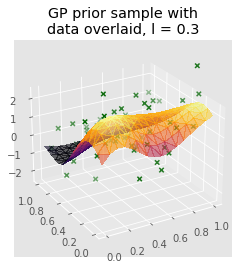

In [6]:
l = 0.3
D = 16
x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
N = D**2

plot_result(u, v, x, y, x[idx], y[idx], title=f'GP prior sample with\ndata overlaid, l = {l}')      

### Question b)

In [7]:
n = 10000
beta = 0.2
u0 = Kc @ np.random.randn(N,)

In [10]:
# grw_as = []
# pcn_as = []
# for _ in tqdm(range(25)):
#     x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
#     grw_as.append(grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)[1])
#     pcn_as.append(pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)[1])

100%|██████████| 25/25 [07:39<00:00, 18.40s/it]

0.077684


In [11]:
# print(np.array(grw_as).mean())
# print(np.array(pcn_as).mean())

0.077684
0.45181200000000005


In [8]:
grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)
print("\n acceptance ratio: {}".format(grw_a))

GRW iterations:


100%|██████████| 10000/10000 [01:02<00:00, 160.14it/s]


 acceptance ratio: 0.0752


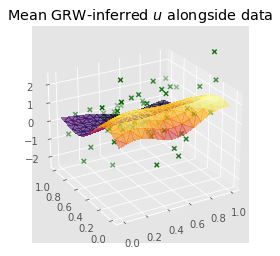

In [9]:
u_grw = np.mean(grw_samps[0::800], axis=0)
plot_result(u_grw, v, x, y, x[idx], y[idx], title="Mean GRW-inferred $u$ alongside data")  

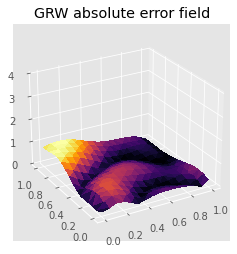

In [10]:
plot_3D(np.abs(u-u_grw), x, y, title='GRW absolute error field', zlim=[0, 4])

In [11]:
pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)
print("\n acceptance ratio: {}".format(pcn_a))

pCN iterations:


100%|██████████| 10000/10000 [00:06<00:00, 1495.00it/s]


 acceptance ratio: 0.437


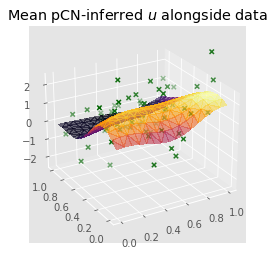

In [12]:
u_pcn = np.mean(pcn_samps[0::200], axis=0)
plot_result(u_pcn, v, x, y, x[idx], y[idx], title="Mean pCN-inferred $u$ alongside data") 

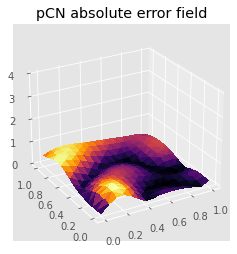

In [13]:
plot_3D(np.abs(u-u_pcn), x, y, title='pCN absolute error field', zlim=[0, 4])

In [27]:
Kc_inv = np.linalg.inv(Kc)
K_inv = Kc_inv.T @ Kc_inv

In [28]:
pcn_samp_lpps = np.array([log_prior(pcn_samps[i,:], K_inv) for i in range(pcn_samps.shape[0])])

In [16]:
grw_samp_lpps = np.array([log_prior(grw_samps[i,:], K_inv) for i in range(grw_samps.shape[0])])

In [20]:
pcn_samp_ltps = np.array([log_continuous_target(pcn_samps[i,:], v, K_inv, G) for i in range(pcn_samps.shape[0])])

In [18]:
grw_samp_ltps = np.array([log_continuous_target(grw_samps[i,:], v, K_inv, G) for i in range(grw_samps.shape[0])])

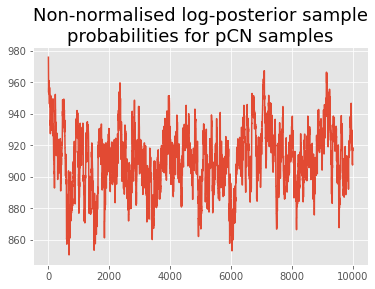

In [21]:
plt.plot(pcn_samp_ltps)
plt.title("Non-normalised log-posterior sample\nprobabilities for pCN samples", fontsize=18)
plt.show()

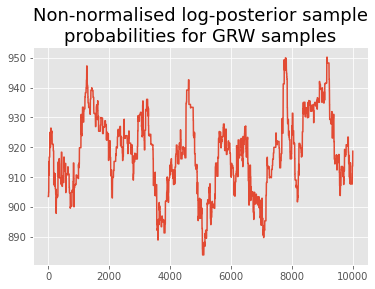

In [20]:
plt.plot(grw_samp_ltps)
plt.title("Non-normalised log-posterior sample\nprobabilities for GRW samples", fontsize=18)
plt.show()

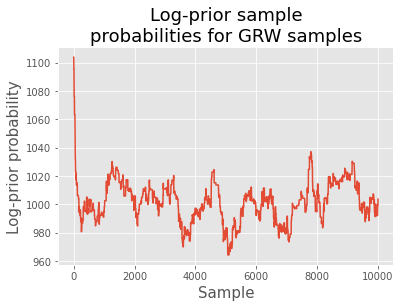

In [21]:
plt.plot(grw_samp_lpps)
plt.title("Log-prior sample\nprobabilities for GRW samples", fontsize=18)
plt.xlabel('Sample', fontsize=15)
plt.ylabel('Log-prior probability', fontsize=15)
plt.show()

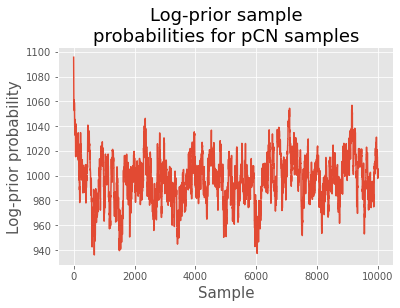

In [29]:
plt.plot(pcn_samp_lpps)
plt.title("Log-prior sample\nprobabilities for pCN samples", fontsize=18)
plt.xlabel('Sample', fontsize=15)
plt.ylabel('Log-prior probability', fontsize=15)
plt.show()

In [21]:
N = grw_samps.shape[1]
r = 1001
a = np.zeros((N, r))
b = np.zeros((N, r))
for i in tqdm(range(N)):
    for j in range(r):
        a[i,j] = pd.Series.autocorr(pd.Series(grw_samps[:,i]), lag=j)
        b[i,j] = pd.Series.autocorr(pd.Series(pcn_samps[:,i]), lag=j)

100%|██████████| 256/256 [04:36<00:00,  1.08s/it]


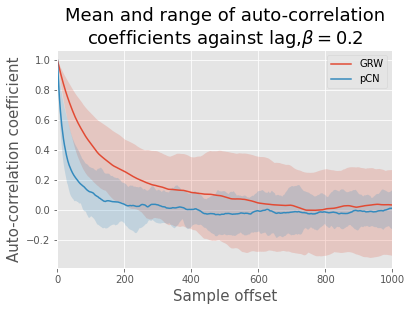

In [22]:
plt.plot(np.arange(r), a.mean(axis=0), label='GRW')
plt.fill_between(np.arange(r), a.max(axis=0), a.min(axis=0), alpha=0.2)
plt.plot(np.arange(r), b.mean(axis=0), label='pCN')
plt.fill_between(np.arange(r), b.max(axis=0), b.min(axis=0), alpha=0.2)
plt.title('Mean and range of auto-correlation\ncoefficients against lag,'+r'$\beta=0.2$', fontsize=18)
plt.ylabel('Auto-correlation coefficient', fontsize=15)
plt.xlabel('Sample offset', fontsize=15)
plt.xlim(0, r-1)
plt.legend()
plt.show()

In [44]:
l = 0.3
D = 16
x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
N = D**2

n = 10000
u0 = Kc @ np.random.randn(N,)
beta = 0.6
grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)
pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)

GRW iterations:


100%|██████████| 10000/10000 [00:14<00:00, 675.84it/s]


pCN iterations:


100%|██████████| 10000/10000 [00:01<00:00, 8152.16it/s]


In [45]:
N = grw_samps.shape[1]
r = 1001
a = np.zeros((N, r))
b = np.zeros((N, r))
for i in tqdm(range(N)):
    for j in range(r):
        a[i,j] = pd.Series.autocorr(pd.Series(grw_samps[:,i]), lag=j)
        b[i,j] = pd.Series.autocorr(pd.Series(pcn_samps[:,i]), lag=j)

100%|██████████| 256/256 [04:48<00:00,  1.13s/it]


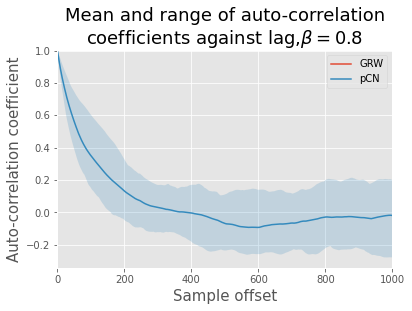

In [46]:
plt.plot(np.arange(r), a.mean(axis=0), label='GRW')
plt.fill_between(np.arange(r), a.max(axis=0), a.min(axis=0), alpha=0.2)
plt.plot(np.arange(r), b.mean(axis=0), label='pCN')
plt.fill_between(np.arange(r), b.max(axis=0), b.min(axis=0), alpha=0.2)
plt.title('Mean and range of auto-correlation\ncoefficients against lag,'+r'$\beta=0.8$', fontsize=18)
plt.ylabel('Auto-correlation coefficient', fontsize=15)
plt.xlabel('Sample offset', fontsize=15)
plt.xlim(0, r-1)
plt.ylim(top=1.001)
plt.legend()
plt.show()

In [26]:
beta = 0.005
grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)
pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)

GRW iterations:


100%|██████████| 10000/10000 [00:19<00:00, 506.61it/s]


pCN iterations:


100%|██████████| 10000/10000 [00:01<00:00, 5809.98it/s]


In [27]:
N = grw_samps.shape[1]
r = 1001
a = np.zeros((N, r))
b = np.zeros((N, r))
for i in tqdm(range(N)):
    for j in range(r):
        a[i,j] = pd.Series.autocorr(pd.Series(grw_samps[:,i]), lag=j)
        b[i,j] = pd.Series.autocorr(pd.Series(pcn_samps[:,i]), lag=j)

100%|██████████| 256/256 [05:02<00:00,  1.18s/it]


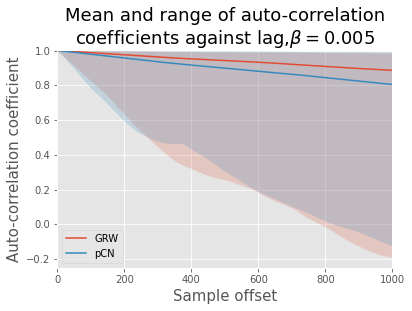

In [28]:
plt.plot(np.arange(r), a.mean(axis=0), label='GRW')
plt.fill_between(np.arange(r), a.max(axis=0), a.min(axis=0), alpha=0.2)
plt.plot(np.arange(r), b.mean(axis=0), label='pCN')
plt.fill_between(np.arange(r), b.max(axis=0), b.min(axis=0), alpha=0.2)
plt.title('Mean and range of auto-correlation\ncoefficients against lag,'+r'$\beta=0.005$', fontsize=18)
plt.ylabel('Auto-correlation coefficient', fontsize=15)
plt.xlabel('Sample offset', fontsize=15)
plt.xlim(0, r-1)
plt.ylim(top=1.001)
plt.legend()
plt.show()

In [7]:
l = 0.2
Ds = [i for i in range(2, 16+1)]

n = 10000
beta = 0.2

mean_grw_as = []
mean_grw_rmses = []
mean_pcn_as = []
mean_pcn_rmses = []

for i in tqdm(range(len(Ds))):
    grw_as = []
    grw_rmses = []
    pcn_as = []
    pcn_rmses = []
    D = Ds[i]
    N = D**2
    for _ in range(8):
        x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
        u0 = Kc @ np.random.randn(N)
        grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        grw_as.append(grw_a)
        grw_rmses.append(rmse(u, grw_samps.mean(axis=0)))
        pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        pcn_as.append(pcn_a)
        pcn_rmses.append(rmse(u, pcn_samps.mean(axis=0)))
    mean_grw_as.append(sum(grw_as)/len(grw_as))
    mean_grw_rmses.append(sum(grw_rmses)/len(grw_rmses))
    mean_pcn_as.append(sum(pcn_as)/len(pcn_as))
    mean_pcn_rmses.append(sum(pcn_rmses)/len(pcn_rmses))

100%|██████████| 15/15 [12:10<00:00, 48.72s/it] 


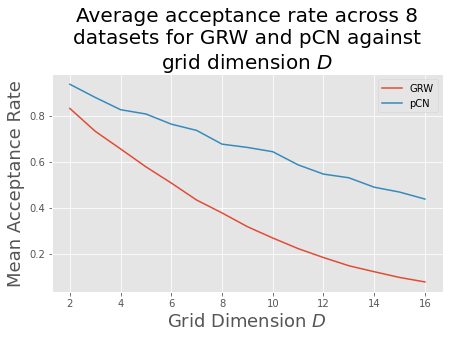

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# ax[0].plot(Ds, mean_grw_rmses, label='GRW')
# ax[0].plot(Ds, mean_pcn_rmses, label='pCN')
# ax[0].set_xlabel('Grid Dimension $D$')
# ax[0].set_ylabel('Mean RMSE')
# ax[0].set_title('Average RMSE across four datasets for GRW\nand pCN as a function of grid dimension $D$')
# ax[0].legend()

ax.plot(Ds, mean_grw_as, label='GRW')
ax.plot(Ds, mean_pcn_as, label='pCN')
ax.set_xlabel(r'Grid Dimension $D$', fontsize=18)
ax.set_ylabel('Mean Acceptance Rate', fontsize=18)
ax.set_title('Average acceptance rate across 8\ndatasets for GRW and pCN against\ngrid dimension $D$', fontsize=20)
ax.legend()

plt.show()

In [15]:
l = 0.2
D = 10
N = D**2

n = 10000
betas = np.linspace(0, 1, 20)

mean_grw_as1 = []
mean_grw_rmses1 = []
mean_pcn_as1 = []
mean_pcn_rmses1 = []

for i in tqdm(range(len(betas))):
    grw_as = []
    grw_rmses = []
    pcn_as = []
    pcn_rmses = []
    beta = betas[i]
    for _ in range(8):
        x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
        u0 = Kc @ np.random.randn(N)
        grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        grw_as.append(grw_a)
        grw_rmses.append(rmse(u, grw_samps.mean(axis=0)))
        pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        pcn_as.append(pcn_a)
        pcn_rmses.append(rmse(u, pcn_samps.mean(axis=0)))
    mean_grw_as1.append(sum(grw_as)/len(grw_as))
    mean_grw_rmses1.append(sum(grw_rmses)/len(grw_rmses))
    mean_pcn_as1.append(sum(pcn_as)/len(pcn_as))
    mean_pcn_rmses1.append(sum(pcn_rmses)/len(pcn_rmses))

100%|██████████| 20/20 [1:36:48<00:00, 290.40s/it]


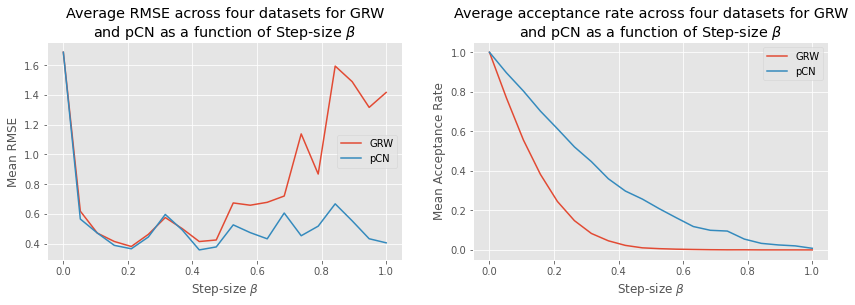

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(betas, mean_grw_rmses1, label='GRW')
ax[0].plot(betas, mean_pcn_rmses1, label='pCN')
ax[0].set_xlabel(r'Step-size $\beta$')
ax[0].set_ylabel('Mean RMSE')
ax[0].set_title('Average RMSE across four datasets for GRW\n'+r'and pCN as a function of Step-size $\beta$')
ax[0].legend()

ax[1].plot(betas, mean_grw_as1, label='GRW')
ax[1].plot(betas, mean_pcn_as1, label='pCN')
ax[1].set_xlabel(r'Step-size $\beta$')
ax[1].set_ylabel('Mean Acceptance Rate')
ax[1].set_title('Average acceptance rate across four datasets for GRW\n'+r'and pCN as a function of Step-size $\beta$')
ax[1].legend()

plt.show()

In [11]:
l = 0.2
D = 10
N = D**2

n = 10000
betas1 = np.logspace(-3, 0, 20)

mean_grw_as3 = []
mean_grw_rmses3 = []
mean_pcn_as3 = []
mean_pcn_rmses3 = []

for i in tqdm(range(len(betas1))):
    grw_as = []
    grw_rmses = []
    pcn_as = []
    pcn_rmses = []
    beta = betas1[i]
    for _ in range(8):
        x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
        u0 = Kc @ np.random.randn(N)
        grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        grw_as.append(grw_a)
        grw_rmses.append(rmse(u, grw_samps.mean(axis=0)))
        pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        pcn_as.append(pcn_a)
        pcn_rmses.append(rmse(u, pcn_samps.mean(axis=0)))
    mean_grw_as3.append(sum(grw_as)/len(grw_as))
    mean_grw_rmses3.append(sum(grw_rmses)/len(grw_rmses))
    mean_pcn_as3.append(sum(pcn_as)/len(pcn_as))
    mean_pcn_rmses3.append(sum(pcn_rmses)/len(pcn_rmses))

100%|██████████| 20/20 [17:56<00:00, 53.84s/it]


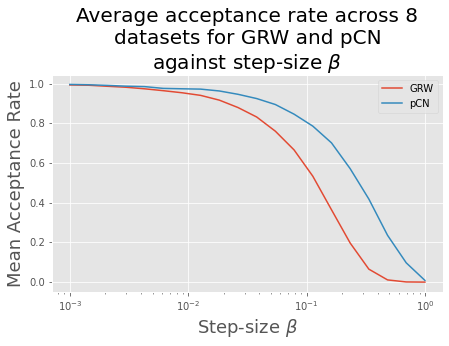

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# ax[0].plot(betas1, mean_grw_rmses3, label='GRW')
# ax[0].plot(betas1, mean_pcn_rmses3, label='pCN')
# ax[0].set_xlabel(r'Step-size $\beta$')
# ax[0].set_ylabel('Mean RMSE')
# ax[0].set_title('Average RMSE across eight datasets for GRW\n'+r'and pCN as a function of step-size $\beta$')
# ax[0].set_xscale('log')
# ax[0].legend()

ax.plot(betas1, mean_grw_as3, label='GRW')
ax.plot(betas1, mean_pcn_as3, label='pCN')
ax.set_xlabel(r'Step-size $\beta$', fontsize=18)
ax.set_ylabel('Mean Acceptance Rate', fontsize=18)
ax.set_title('Average acceptance rate across 8\ndatasets for GRW and pCN\n' +r'against step-size $\beta$', fontsize=20)
ax.set_xscale('log')
ax.legend()

plt.show()

In [6]:
l = 0.3
Ds = [i for i in range(4, 16+1)]
M = Ds[0]**2

n = 10000
beta = 0.2

mean_grw_as2 = []
mean_grw_rmses2 = []
mean_pcn_as2 = []
mean_pcn_rmses2 = []

for i in tqdm(range(len(Ds))):
    grw_as = []
    grw_rmses = []
    pcn_as = []
    pcn_rmses = []
    D = Ds[i]
    N = D**2
    for _ in range(8):
        x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l, N_sub=M)
        u0 = Kc @ np.random.randn(N)
        grw_samps, grw_a = grw(log_target=log_continuous_target, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        grw_as.append(grw_a)
        grw_rmses.append(rmse(u, grw_samps.mean(axis=0)))
        pcn_samps, pcn_a = pcn(log_likelihood=log_continuous_likelihood, u0=u0, data=v, K=Kc@Kc.T, G=G, n_iters=n, beta=beta, silence=True)
        pcn_as.append(pcn_a)
        pcn_rmses.append(rmse(u, pcn_samps.mean(axis=0)))
    mean_grw_as2.append(sum(grw_as)/len(grw_as))
    mean_grw_rmses2.append(sum(grw_rmses)/len(grw_rmses))
    mean_pcn_as2.append(sum(pcn_as)/len(pcn_as))
    mean_pcn_rmses2.append(sum(pcn_rmses)/len(pcn_rmses))

100%|██████████| 13/13 [13:07<00:00, 60.55s/it] 


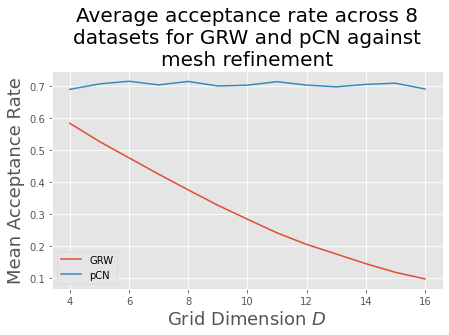

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# ax[0].plot(Ds, mean_grw_rmses2, label='GRW')
# ax[0].plot(Ds, mean_pcn_rmses2, label='pCN')
# ax[0].set_xlabel('Grid Dimension $D$')
# ax[0].set_ylabel('Mean RMSE')
# ax[0].set_title('Average RMSE across four datasets for GRW\nand pCN as a function of grid dimension $D$\nfor fixed dataset size')
# ax[0].legend()

ax.plot(Ds, mean_grw_as2, label='GRW')
ax.plot(Ds, mean_pcn_as2, label='pCN')
ax.set_xlabel('Grid Dimension $D$', fontsize=18)
ax.set_ylabel('Mean Acceptance Rate', fontsize=18)
ax.set_title('Average acceptance rate across 8\ndatasets for GRW and pCN against\nmesh refinement', fontsize=20)
ax.legend()

plt.show()

### Question c)

In [14]:
l = 0.25
D = 16
x, y, u, v, xi, yi, idx, coords, Kc, G = generate_data(D=D, l=l)
N = D**2
u0 = Kc @ np.random.randn(N,)

In [15]:
n = 10000
beta = 0.2
t = probit(v)
thin = 200

pcn_prob_samps, pcn_prob_a = pcn(log_likelihood=log_probit_likelihood, u0=u0, data=t, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)
probit_probs = predict_t(pcn_prob_samps[::thin])

pCN iterations:


100%|██████████| 10000/10000 [00:03<00:00, 2963.33it/s]


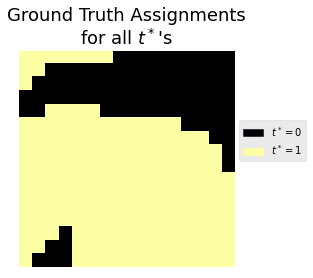

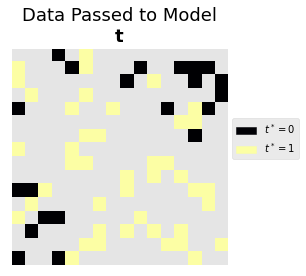

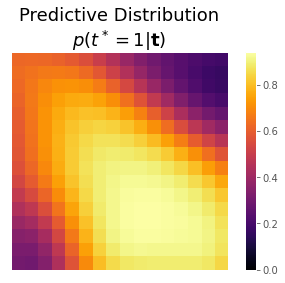

In [16]:
plot_2D(probit(u), xi, yi, title='Ground Truth Assignments\n'+r"for all $t^*$'s", classify=True)
plot_2D(t, xi[idx], yi[idx], title='Data Passed to Model\n'+r'$\mathbf{t}$', classify=True)
# plot_2D(pcn_prob_samps[::thin].mean(axis=0), xi, yi)
plot_2D(probit_probs, xi, yi, title='Predictive Distribution\n'+r'$p(t^*=1|\mathbf{t})$')

### Question d)

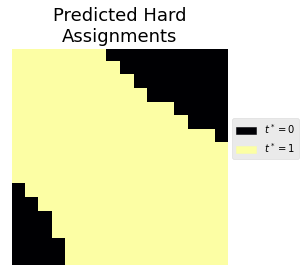

In [17]:
plot_2D(hard_assign(probit_probs), xi, yi, classify=True, title='Predicted Hard\nAssignments')

In [18]:
grains = 500
ls = np.logspace(-2, 1, grains)
Ks = np.array([GaussianKernel(coords, l) for l in ls])

true_errors = []
data_errors = []
for K in tqdm(Ks):
    samps = pcn(log_likelihood=log_probit_likelihood, u0=u0, data=t, K=K, G=G, n_iters=n, beta=beta, silence=True)[0][::thin]
    pred_t = hard_assign(predict_t(samps))
    true_errors.append(mean_pred_error(pred_t, probit(u)))
    data_errors.append(mean_pred_error(G@pred_t, v))

100%|██████████| 500/500 [45:37<00:00,  5.47s/it] 


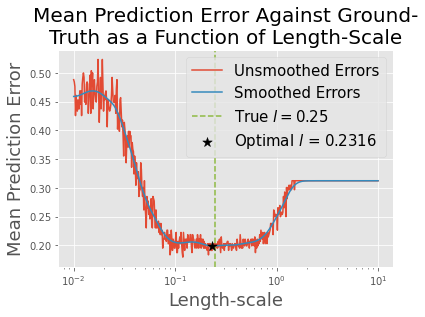

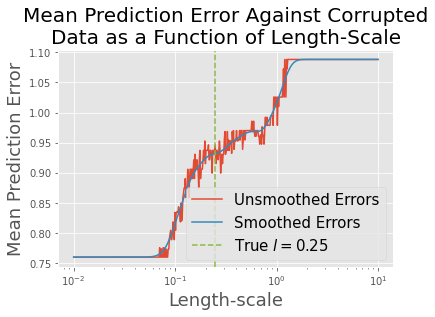

In [27]:
# fig, ax = plt.subplots(1, 2, figsize=(14, 4))

smoothed_te = gaussian_filter1d(true_errors, 10)

plt.plot(ls, true_errors, label='Unsmoothed Errors')
plt.plot(ls, smoothed_te, label='Smoothed Errors')
opt_l_ind = np.argmin(smoothed_te)
opt_te = smoothed_te[opt_l_ind]
plt.axvline(x=0.25, linestyle='--', label=r'True $l = 0.25$', color='C5')
plt.scatter(ls[opt_l_ind], opt_te, label=r'Optimal $l$'+f' = {round(ls[opt_l_ind], 4)}', color='black', zorder=5, marker='*', s=100)
plt.xscale('log')
plt.title('Mean Prediction Error Against Ground-\nTruth as a Function of Length-Scale', fontsize=20)
plt.xlabel('Length-scale', fontsize=18)
plt.ylabel('Mean Prediction Error', fontsize=18)
plt.legend(fontsize=15)

plt.show()


plt.plot(ls, data_errors, label='Unsmoothed Errors')
plt.plot(ls, gaussian_filter1d(data_errors, 10), label='Smoothed Errors')
plt.axvline(x=0.25, linestyle='--', label=r'True $l = 0.25$', color='C5')
plt.xscale('log')
plt.title('Mean Prediction Error Against Corrupted\nData as a Function of Length-Scale', fontsize=20)
plt.xlabel('Length-scale', fontsize=18)
plt.ylabel('Mean Prediction Error', fontsize=18)
plt.legend(fontsize=15)

plt.show()

In [24]:
grains = 500
ls = np.logspace(-2, 1, grains)
lmls = []

for l in tqdm(ls):
    lmls.append(est_log_evidence(l, G, t, log_probit_likelihood, n_samps=100000))
    
lmls = np.array(lmls)

100%|██████████| 500/500 [11:09<00:00,  1.34s/it]


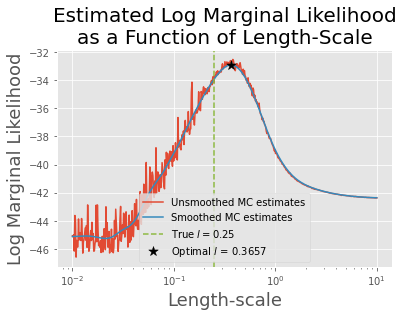

In [26]:
smoothed_lmls = gaussian_filter1d(lmls, 10)
opt_l_ind = np.argmax(smoothed_lmls)
opt_ml = smoothed_lmls[opt_l_ind]
plt.plot(ls, lmls, label='Unsmoothed MC estimates')
plt.plot(ls, smoothed_lmls, label='Smoothed MC estimates')
plt.axvline(x=0.25, linestyle='--', label=r'True $l = 0.25$', color='C5')
plt.scatter(ls[opt_l_ind], opt_ml, label=r'Optimal $l$'+f' = {round(ls[opt_l_ind], 4)}', color='black', zorder=5, marker='*', s=100)
plt.xscale('log')
plt.title('Estimated Log Marginal Likelihood\nas a Function of Length-Scale', fontsize=20)
plt.xlabel('Length-scale', fontsize=18)
plt.ylabel('Log Marginal Likelihood', fontsize=18)
plt.legend()

plt.show()

In [406]:
# l = 0.2
# D = 16
# coords = [(x, y) for y in np.linspace(0, 1, D) for x in np.linspace(0, 1, D)]
# N = D**2
# K = GaussianKernel(coords, l)
# Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
# beta = 0.2
# samps = pcn(log_likelihood=log_probit_likelihood, u0=u0, data=t, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)[0][::50]
# u_star = samps.mean(axis=0)

In [407]:
# print(chib_est_log_evidence(u_star, Kc, t, G, samps, beta=beta))
# print(est_log_evidence(l, G, t))

In [408]:
# grains = 20
# ls = np.logspace(-2, 1, grains)
# Ks = np.array([GaussianKernel(coords, l) for l in ls])

# ch_lmls = []

# for K in tqdm(Ks):
#     samps = pcn(log_likelihood=log_probit_likelihood, u0=u0, data=t, K=K, G=G, n_iters=n, beta=beta, silence=True)[0][::thin]
#     Kc_i = np.linalg.cholesky(K + 1e-6 * np.eye(N))
#     u_star = samps.mean(axis=0)
#     ch_lmls.append(chib_est_log_evidence(u_star, Kc_i, t, G, samps, beta=beta))
    
# ch_lmls = np.array(ch_lmls)

In [409]:
# plt.plot(ls, ch_lmls)
# # plt.plot(ls, lmls)
# plt.xscale('log')
# # plt.ylim([-75, 0])
# plt.title('Naive-Monte-Carlo-Estimated Log\nMarginal Likelihood as a Function of\nLength-Scale', fontsize=18)
# plt.xlabel('Length-scale', fontsize=15)
# plt.ylabel('Log Marginal Likelihood', fontsize=15)

# plt.show()